# MERGED MODEL

## Prepare Library, Parameters, and Dependencies for Segmentation and Classification

In [20]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import os
from tqdm import tqdm

In [21]:
# UNCOMMENT THIS IF YOU USE GOOGLE COLAB

# from google.colab import drive
# drive.mount('/content/drive')

In [22]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  0


In [23]:
SEG_DATASET_DIR = "datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/"
CLASS_DATASET_DIR = "/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/classification_datasets/cataract_dataset_mixed_blended/"
TEST_PREDICT_DIR = "/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/"

BATCH_SIZE_SEG = 8
VAL_RATIO_SEG = 0.2
SHUFFLE_BUFFER_SIZE_SEG = 10000

BATCH_SIZE_CLASS = 16
VAL_RATIO_CLASS = 0.3
SHUFFLE_BUFFER_SIZE_CLASS = 1100

IMG_HEIGHT = 128
IMG_WIDTH = 128

SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

## Preparing and Preprocessing Segmentation Dataset

#### Load Segmentation Dataset

In [24]:
# USE THIS IF YOU USE LOCAL MACHINE

# # Load OG Image Path
# image_path = []
# for root, dirs, files in os.walk(SEG_DATASET_DIR + "train_original/"):
#     for file in tqdm(files):
#         if file.endswith(".jpg"):
#              image_path.append(os.path.join(root, file))
#
# # Load Mask Image Path
# mask_path = []
# for root, dirs, files in os.walk(SEG_DATASET_DIR + "train_mask/"):
#     for file in tqdm(files):
#         if file.endswith(".jpg"):
#              mask_path.append(os.path.join(root, file))
#
# # Verify Length and Consistency OG and Mask Image
# print(len(image_path))
# print(image_path[1])
#
# print(len(mask_path))
# print(mask_path[1])

In [25]:
# USE THIS IF YOU USE GOOGLE COLAB

# Load OG Image and Mask Image Path
image_path = []
mask_path = []
for root, dirs, files in os.walk(SEG_DATASET_DIR + "train_original/"):
    for file in tqdm(files):
        path_og = os.path.join(root,file)
        path_mask = os.path.join(SEG_DATASET_DIR + "train_mask/", file)
        image_path.append(path_og)
        mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(image_path))
print(image_path[1])

print(len(mask_path))
print(mask_path[1])

100%|██████████| 1476/1476 [00:00<00:00, 101165.01it/s]

1476
datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_original/mild_10.jpg
1476
datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_mask/mild_10.jpg


#### Decode Segmentation Dataset Into Array

In [26]:
# Decode Mask Image
masks = []
for path in tqdm(mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    masks.append(mask_array)

# Decode OG Image
images = []
for path in tqdm(image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    images.append(img_array)

100%|██████████| 1476/1476 [00:03<00:00, 390.60it/s]


#### Resize Segmentation Dataset

In [27]:
# Resize Function for OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

# Resize Function for Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

# Looping Resize Function for OG and Mask Image Dataset
X = [resize_image(image) for image in images]
y = [resize_mask(mask) for mask in masks]

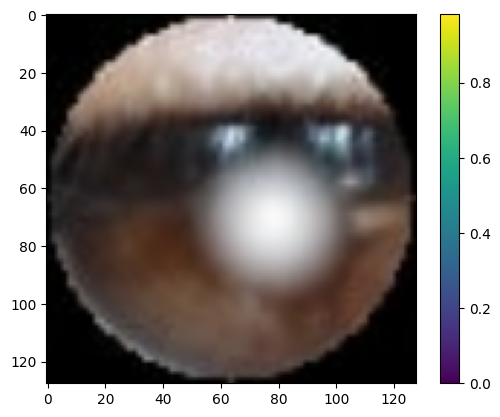

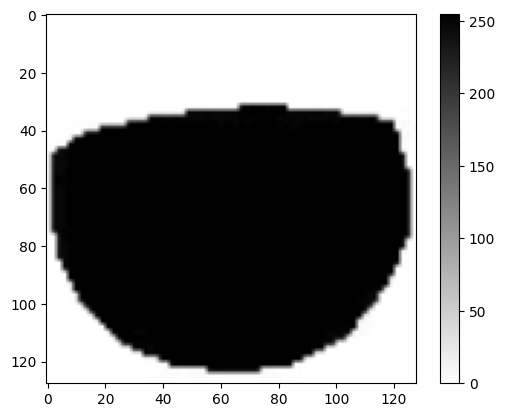

In [28]:
# Visualizing a Resized Image and Respective Mask

# Plot an OG Image
plt.imshow(X[36])
plt.colorbar()
plt.show()

# Plot a Mask
plt.imshow(y[36], cmap='binary')
plt.colorbar()
plt.show()

#### Grayscaling Segmentation Dataset

In [32]:
# Function to Convert OG Image to Grayscale
def convert_to_grayscale(image):
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image

# Looping Grayscaling Function for OG Image Dataset
X = [convert_to_grayscale(image) for image in X]

In [ ]:
# Visualizing a Resized Image and Respective Mask

# Plot an OG Image
plt.imshow(X[36])
plt.colorbar()
plt.show()

# Plot a Mask
plt.imshow(y[36], cmap='binary')
plt.colorbar()
plt.show()

#### Split Segmentation Dataset and Change Dataset to TensorFlow Dataset

In [ ]:
# Split Dataset With 80/20 Ratio
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_RATIO_SEG, random_state=42)

# Change Dataset Into TensorFlow Dataset
X_train = tf.data.Dataset.from_tensor_slices(X_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
X_val = tf.data.Dataset.from_tensor_slices(X_val)
y_val = tf.data.Dataset.from_tensor_slices(y_val)

# Verify the Shapes and Data Types
X_train.element_spec, y_train.element_spec, X_val.element_spec, y_val.element_spec

#### Segmentation Dataset Augmentation

In [ ]:
# Augmentation Function
def brightness(image, mask):
    image = tf.image.adjust_brightness(image, 0.1)
    return image, mask

def gamma(image, mask):
    image = tf.image.adjust_gamma(image, 0.1)
    return image, mask

def hue(image, mask):
    image = tf.image.adjust_hue(image, -0.1)
    return image, mask

def crop(image, mask):
    image = tf.image.central_crop(image, 0.7)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return image, mask

def flip_hori(image, mask):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    return image, mask

def flip_vert(image, mask):
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)
    return image, mask

def rotate(image, mask):
    image = tf.image.rot90(image)
    mask = tf.image.rot90(mask)
    return image, mask

In [ ]:
# Zip Dataset
train = tf.data.Dataset.zip((X_train, y_train))
val = tf.data.Dataset.zip((X_val, y_val))

# Perform Data Augmentation
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(gamma))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(crop))
train = train.concatenate(train.map(flip_hori))
train = train.concatenate(train.map(flip_vert))
train = train.concatenate(train.map(rotate))

#### Segmentation Dataset Pipelining

In [ ]:
train = train.cache().shuffle(SHUFFLE_BUFFER_SIZE_SEG).batch(BATCH_SIZE_SEG).repeat()
train = train.prefetch(AUTOTUNE)
val = val.batch(BATCH_SIZE_SEG)

## Preparing and Preprocessing Classification Dataset

#### Load and Split Classification Dataset

In [ ]:
# Make Train Dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=CLASS_DATASET_DIR,
    validation_split=VAL_RATIO_CLASS,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_CLASS,
    shuffle=SHUFFLE_VALUE,
)

# Make Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory=CLASS_DATASET_DIR,
    validation_split=VAL_RATIO_CLASS,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_CLASS,
    shuffle=SHUFFLE_VALUE,
)

# Make Test Dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 3)
val_ds = val_ds.skip(val_batches // 3)

# Print Dataset Information
print(f'Number of training batches: {len(np.concatenate([i for x, i in train_ds]))}')
print(f'Number of validation batches: {len(np.concatenate([i for x, i in val_ds]))}')
print(f'Number of test batches: {len(np.concatenate([i for x, i in test_ds]))}')

train_visualize = train_ds

#### Classification Dataset Augmentation

In [ ]:
# Augmentation Sequential
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip(mode='horizontal'),
    keras.layers.RandomRotation(factor=0.4),
    keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
])

#### Classification Dataset Pipelining

In [ ]:
train_ds = train_ds.cache().shuffle(SHUFFLE_BUFFER_SIZE_CLASS)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

## Visualize All Dataset

#### Visualize Segmentation Dataset

In [ ]:
# Visualize Dataset OG Image
plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.colorbar()
    plt.axis("off")

plt.show()

In [ ]:
# Normalize Color Map for Mask Image
NORM = mpl.colors.Normalize(vmin=0, vmax=1)

# Visualize Dataset Mask Image
plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(masks[i], cmap='binary', norm=NORM)
    plt.colorbar()
    plt.axis("off")

plt.show()

#### Visualize Classification Dataset

In [ ]:
# Return Class Names from Dataset
class_names = train_visualize.class_names
print(class_names)

# Visualize Classification Dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE_CLASS):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Callbacks

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_loss') is not None and logs.get('val_loss') < 0.35:
                print("\nReached <0.3 val_loss so cancelling training!")

                # Stop training once the above condition is met
                self.model.stop_training = True

# Initialize Callbacks Class
callback = myCallback()

## Build Segmentation Model

#### Build U-Net Architecture

In [ ]:
# Encoder Block for Contracting Path in U-Net Architecture
def EncoderBlock(input_layer, n_filter, kernel_size=(3,3), kernel_initializer='he_normal', dropout_prob=0.1, max_pooling=True):
    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(input_layer)

    if dropout_prob > 0:
        x = keras.layers.Dropout(dropout_prob)(x)

    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    if max_pooling:
        next_layer = keras.layers.MaxPooling2D((2,2))(x)
    else:
        next_layer = x

    skip_connection = x

    return next_layer, skip_connection

# Decoder Block for Expansive Path in U-Net Architecture
def DecoderBlock(input_layer, skip_layer, n_filter, kernel_size=(2,2), kernel_initializer='he_normal', dropout_prob=0.1):
    x = keras.layers.Conv2DTranspose(n_filter, kernel_size, strides=(2,2), padding='same')(input_layer)
    x = keras.layers.concatenate([x, skip_layer])
    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    if dropout_prob > 0:
        x = keras.layers.Dropout(dropout_prob)(x)

    next_layer = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    return next_layer

In [ ]:
# Input Layer
input_layer = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3), name="input_image")

# Build Contraction Path
c1, s1 = EncoderBlock(input_layer, 16)
c2, s2 = EncoderBlock(c1, 32)
c3, s3 = EncoderBlock(c2, 64)
c4, s4 = EncoderBlock(c3, 128)
c5, _ = EncoderBlock(c4, 256, max_pooling=False)

# Build Expansive Path
e1 = DecoderBlock(c5, s4, 128)
e2 = DecoderBlock(e1, s3, 64)
e3 = DecoderBlock(e2, s2, 32)
e4 = DecoderBlock(e3, s1, 16)

# Output Layer
output = keras.layers.Conv2D(256, (1,1), activation='sigmoid')(e4)

# Initialize Model
unet = keras.Model(inputs=[input_layer], outputs=[output])

In [ ]:
unet.summary()

#### Compile and Train Model

In [ ]:
unet.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
unet_history = unet.fit(
    train,
    validation_data=val,
    steps_per_epoch=len(X_train) // BATCH_SIZE_SEG,
    validation_steps=len(X_val) // BATCH_SIZE_SEG,
    epochs=50,
    verbose=2,
    callbacks=[callback]
)

## Build Classification Model

#### Build CNN Architecture

In [ ]:
model = tf.keras.Sequential([
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    data_augmentation,
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(class_names))
])

In [ ]:
model.summary()

#### Compile and Train Model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[callback]
)

## Evaluate Model

#### Plot Accuracy and Loss Segmentation Model

In [ ]:
# Retrieve Accuracy and Loss from Segmentation Model
acc = unet_history.history['accuracy']
val_acc = unet_history.history['val_accuracy']
loss = unet_history.history['loss']
val_loss = unet_history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('1st Model Training and Validation Accuracy')

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('1st Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Evaluate Segmentation Model with Test Dataset

In [ ]:
# Load OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk(SEG_DATASET_DIR + "test_original/"):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join(SEG_DATASET_DIR + "test_mask/",file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])
print(len(test_mask_path))
print(test_mask_path[1])

# Decode Test Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    test_masks.append(mask_array)

# Decode Test OG Image
test_images = []
for path in tqdm(test_image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    test_images.append(img_array)

# Initialize Resize Function for OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

# Initialize Resize Function for Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

# Resize Test OG and Mask Image
X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

# Change Dataset Into TensorFlow Dataset
X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

# Dataset Pipelining
test = test.batch(BATCH_SIZE_SEG)

In [ ]:
# Evaluate Model
loss, accuracy = unet.evaluate(test)

In [ ]:
# Select a Validation Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet.predict(img)
plt.figure(figsize=(30,38))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Groundtruth Mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')

    # Plot the Actual Image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()

#### Evaluate Segmentation Model with Real Cataract Image

In [ ]:
# Load OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/', file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])
print(len(test_mask_path))
print(test_mask_path[1])

# Decode Test Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    test_masks.append(mask_array)

# Decode Test OG Image
test_images = []
for path in tqdm(test_image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    test_images.append(img_array)

# Initialize Resize Function for OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

# Initialize Resize Function for Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

# Resize Test OG and Mask Image
X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

# Change Dataset Into TensorFlow Dataset
X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

# Dataset Pipelining
test = test.batch(BATCH_SIZE_SEG)

In [ ]:
# Select a Validation Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Actual Image
    plt.subplot(4,3,2+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()

#### Plot Accuracy and Loss Classification Model

In [ ]:
# Retrieve Accuracy and Loss from Classification Model
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('1st Model Training and Validation Accuracy')

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('1st Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Evaluate Classification Model with Test Dataset

In [ ]:
# Evaluate Model
loss, accuracy = model.evaluate(test_ds)

In [ ]:
# Retrieve a True Label from the Test Dataset
y_true = np.concatenate([i for x, i in test_ds])

# Make Prediction
y_pred = np.argmax(model.predict(test_ds), axis=-1)

# Plot Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

In [ ]:
# Plot Function Confusion Matrix
def show_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=15)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [ ]:
# Show Confusion Matrix
show_confusion_matrix(conf_mat, class_names)

#### Evaluate Classification Model with Real Cataract Image

In [ ]:
# Predict Sequential
predict_model = keras.Sequential([
    model,
    keras.layers.Softmax()
])

In [ ]:
# Predict with Real Cataract Image
for filename in os.listdir(TEST_PREDICT_DIR):
    img = keras.preprocessing.image.load_img(TEST_PREDICT_DIR + filename, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = predict_model.predict(img_array)

    score = tf.nn.softmax(predictions[0])

    print(filename)
    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
    print(predictions)